In [145]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

uint8 (1280, 1280, 3)


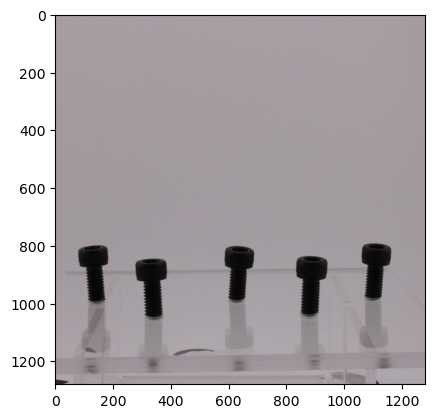

In [146]:
filename = 'substrate_image.jpg'
substrate = ski.io.imread(filename)
print(substrate.dtype, substrate.shape)
plt.imshow(substrate)


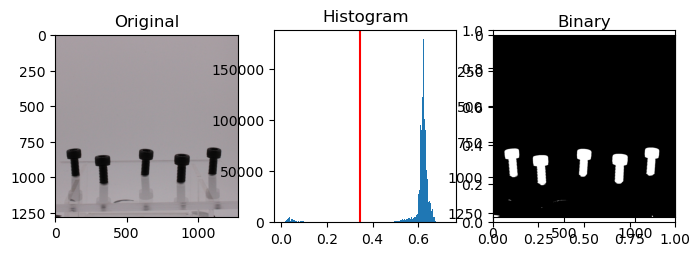

In [147]:
gray = rgb2gray(substrate)
thresh = threshold_otsu(gray)
binary = gray < thresh
mask = binary

fix, axes = plt.subplots(ncols = 3, figsize = (8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex = ax[0], sharey = ax[0])

ax[0].imshow(substrate, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[1].hist(gray.ravel(), bins = 256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color = 'r')
ax[2].imshow(binary, cmap = plt.cm.gray)
ax[2].set_title('Binary')
plt.show()

In [148]:
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
from skimage.measure import label, regionprops

mask = remove_small_holes(mask, area_threshold=5000)

labels = label(mask)
regions = regionprops(labels)

MIN_PART_AREA = 5000
masks = []
for region in regions:
    if region.area >= MIN_PART_AREA:
        part_mask = labels == region.label
        masks.append(part_mask)

isolated_parts = []
for part_mask in masks:
    part_img = substrate.copy()
    clean_image = np.dstack([part_img, (part_mask * 255).astype(np.uint8)])
    isolated_parts.append(clean_image)


/tmp/ipykernel_191872/204855330.py:4: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  mask = remove_small_holes(mask, area_threshold=5000)


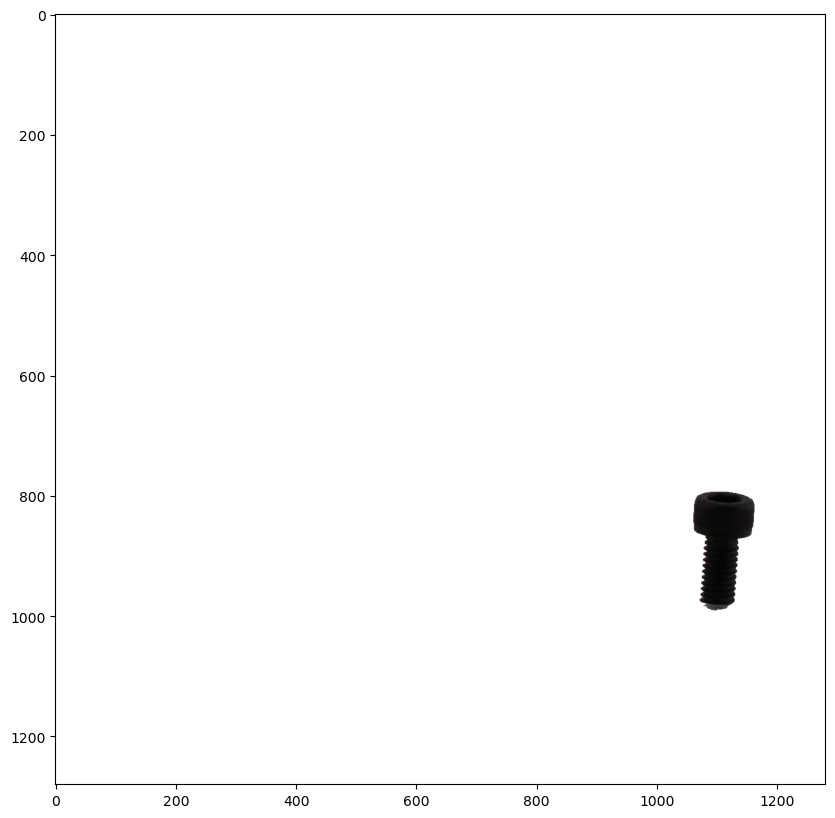

In [149]:
plt.figure(figsize=(10, 10))
plt.imshow(isolated_parts[0])

In [152]:
from skimage.filters import threshold_yen

parts_mask = np.zeros_like(gray, dtype=bool)
for m in masks:
    parts_mask |= m

gray_no_parts = gray.copy()
gray_no_parts[parts_mask] = np.nan

bg_thresh = np.nanpercentile(gray_no_parts, 40)
background_mask = gray_no_parts > bg_thresh

non_background = ~background_mask
non_background[np.isnan(gray_no_parts)] = False

labels = label(non_background)
regions = regionprops(labels)

regions_sorted = sorted(regions, key=lambda r: r.area, reverse=True)

holder_label = regions_sorted[0].label
holder_mask = labels == holder_label

holder_mask = closing(holder_mask, disk(10))
holder_mask = remove_small_holes(holder_mask, 5000)

background_mask = ~(parts_mask | holder_mask)



/tmp/ipykernel_191872/2582109717.py:25: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  holder_mask = remove_small_holes(holder_mask, 5000)


In [153]:

background_only = substrate.copy()
background_only = np.dstack([substrate, (background_mask * 255).astype(np.uint8)])

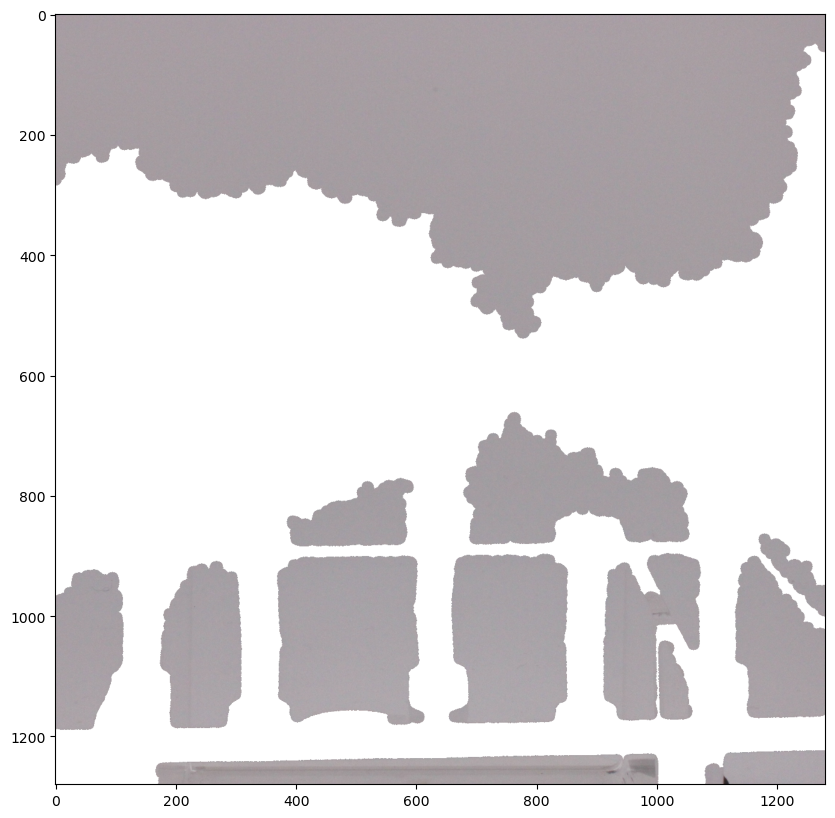

In [154]:
plt.figure(figsize=(10, 10))
plt.imshow(background_only)

In [ ]:
from skimage.color import rgb2lab
# convert to lab color space for better color analysis
lab = rgb2lab(substrate)

# seperate the channels
L = lab[..., 0]
a = lab[..., 1]
b = lab[..., 2]

# analyze the background color properties on a per pixel basis
L_bg = L[background_mask]
a_bg = a[background_mask]
b_bg = b[background_mask]

# analyze the part color properties on a per pixel basis
parts_L = [L[m] for m in masks]
parts_a = [a[m] for m in masks]
parts_b = [b[m] for m in masks]

# calculate reference background color properties for normalization
# uses the median to be robust to outliers and non-uniform background
L_bg_ref = np.median(L_bg)
a_bg_ref = np.median(a_bg)
b_bg_ref = np.median(b_bg)

# normalize part color properties by subtracting the background reference
normalized_parts = []
for m in masks:
    L_norm = L[m] - L_bg_ref
    a_norm = a[m] - a_bg_ref
    b_norm = b[m] - b_bg_ref
    normalized_parts.append((L_norm, a_norm, b_norm))

blackness_per_part = []

for (L_norm, a_norm, b_norm) in normalized_parts:
    blackness = np.percentile(L_norm, 10)
    blackness_per_part.append(blackness)

print(len(masks))

5


In [156]:
from skimage.measure import regionprops, label

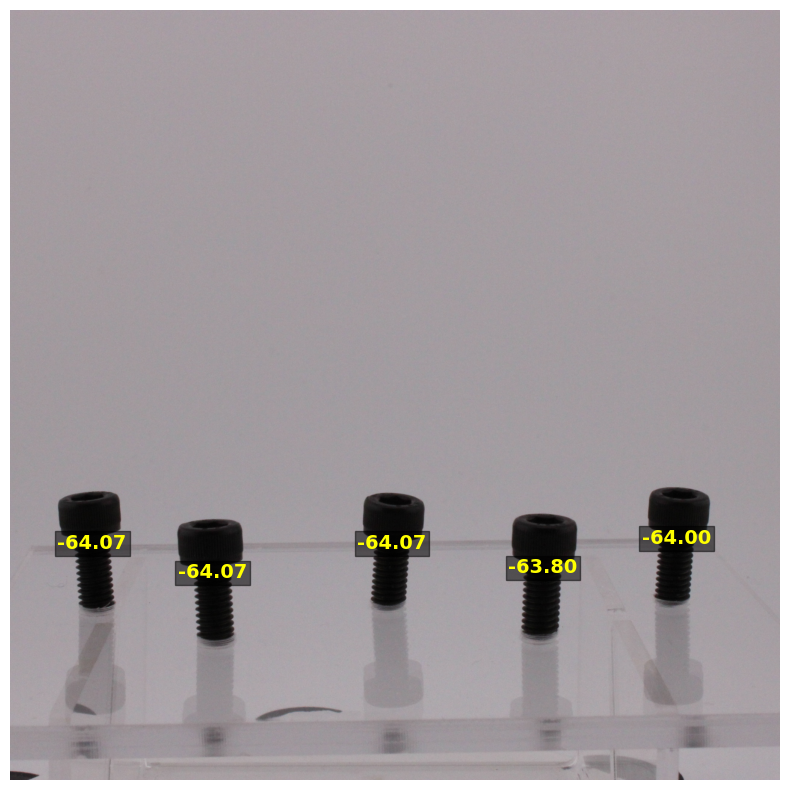

In [160]:
combined = np.zeros_like(masks[0], dtype=int)

for i, pm in enumerate(masks):
    combined[pm] = i + 1

regions = regionprops(combined)

plt.figure(figsize=(10, 10))
plt.imshow(substrate)
plt.axis('off')

for i, region in enumerate(regions):
    y, x = region.centroid
    blackness = blackness_per_part[i]

    plt.text(
        x, y, 
        f'{blackness: .2f}',
        color='yellow',
        fontsize=14,
        weight='bold',
        ha='center',
        va='center',
        bbox=dict(facecolor='black', alpha=0.5, pad=2)
    )